In [1]:
# Appliances Energy Prediction
from ucimlrepo import fetch_ucirepo 
import numpy as np
import torch

import sys
import os

import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from DJGP_test import *
from argparse import Namespace
from JumpGP_test import *
from DeepGP_test import *

# 添加父级目录到系统路径
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
current_dir = os.getcwd()
# 添加父级目录到系统路径
sys.path.append(os.path.dirname(current_dir))

# 然后导入 JumpGP
from JumpGaussianProcess.jumpgp import JumpGP

use_jgp_sir = False
use_jgp_pca = False
use_jgp = False
use_lmjgp = True
use_dgp = False

from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import numpy as np

import pickle
from datetime import datetime
import random

total_res = {} 
Erosion_res = {}
num_exp = 10 
# dataset_candidates = ['Wine Quality', 'Parkinsons Telemonitoring', 'Appliances Energy Prediction']
dataset_candidates = ['Parkinsons Telemonitoring']
dtname = 'Parkinsons'
store_file = f'exp_data/erosion_new_dataset/erosion_K_{dtname}'
os.makedirs(store_file, exist_ok=True)
# num_exp = 1 
# dataset_candidates = ['Wine Quality']
for dataset_name in dataset_candidates:
    total_res[dataset_name] = {}
    for seed in range(num_exp):
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)
        
        if dataset_name == 'Appliances Energy Prediction':
            # fetch dataset 
            appliances_energy_prediction = fetch_ucirepo(id=374) 
            
            # data (as pandas dataframes) 
            X = appliances_energy_prediction.data.features 
            y = appliances_energy_prediction.data.targets 
            
            # metadata 
            print(appliances_energy_prediction.metadata) 
            
            # variable information 
            print(appliances_energy_prediction.variables) 

            X_np = X.iloc[:, 1:].to_numpy()
            y_np = y.to_numpy()

            # np.random.seed(seed)
            indices = np.random.permutation(X_np.shape[0])
            split = int(X_np.shape[0] * 0.97)

            train_idx, test_idx = indices[:split], indices[split:]
            X_train_np, X_test_np = X_np[train_idx], X_np[test_idx]
            y_train_np, y_test_np = y_np[train_idx], y_np[test_idx]

            X_train = torch.from_numpy(X_train_np).float()
            Y_train = torch.from_numpy(y_train_np).float()
            X_test  = torch.from_numpy(X_test_np).float()
            Y_test  = torch.from_numpy(y_test_np).float()

            # 输出形状验证
            print("X_train:", X_train.shape)
            print("y_train:", Y_train.shape)
            print("X_test: ", X_test.shape)
            print("y_test: ", Y_test.shape)

            K = 5
        elif dataset_name == 'Parkinsons Telemonitoring':
            # Parkinsons Telemonitoring
            # fetch dataset 
            parkinsons_telemonitoring = fetch_ucirepo(id=189) 
            
            # data (as pandas dataframes) 
            X = parkinsons_telemonitoring.data.features 
            y = parkinsons_telemonitoring.data.targets 
            
            # metadata 
            print(parkinsons_telemonitoring.metadata) 
            
            # variable information 
            print(parkinsons_telemonitoring.variables) 
            
            X_np = X.to_numpy()
            y_np = y.to_numpy()
            indices = np.random.permutation(X_np.shape[0])
            split = int(X_np.shape[0] * 0.9)

            train_idx, test_idx = indices[:split], indices[split:]
            X_train_np, X_test_np = X_np[train_idx,:-1], X_np[test_idx,:-1]
            y_train_np, y_test_np = y_np[train_idx, 0], y_np[test_idx, 0]

            X_train = torch.from_numpy(X_train_np).float()
            Y_train = torch.from_numpy(y_train_np).float()
            X_test  = torch.from_numpy(X_test_np).float()
            Y_test  = torch.from_numpy(y_test_np).float()

            # 输出形状验证
            print("X_train:", X_train.shape)
            print("y_train:", Y_train.shape)
            print("X_test: ", X_test.shape)
            print("y_test: ", Y_test.shape)
            K = 5
        elif dataset_name == 'Wine Quality':
            wine_quality = fetch_ucirepo(id=186) 
        
            # data (as pandas dataframes) 
            X = wine_quality.data.features 
            y = wine_quality.data.targets 
            
            # metadata 
            print(wine_quality.metadata) 
            
            # variable information 
            print(wine_quality.variables) 

            # np.random.seed(seed)
            X_np = X.to_numpy()
            y_np = y.to_numpy()
            indices = np.random.permutation(X_np.shape[0])
            split = int(X_np.shape[0] * 0.9)

            train_idx, test_idx = indices[:split], indices[split:]
            X_train_np, X_test_np = X_np[train_idx,:], X_np[test_idx,:]
            y_train_np, y_test_np = y_np[train_idx, 0], y_np[test_idx, 0]

            X_train = torch.from_numpy(X_train_np).float()
            Y_train = torch.from_numpy(y_train_np).float()
            X_test  = torch.from_numpy(X_test_np).float()
            Y_test  = torch.from_numpy(y_test_np).float()

            # 输出形状验证
            print("X_train:", X_train.shape)
            print("y_train:", Y_train.shape)
            print("X_test: ", X_test.shape)
            print("y_test: ", Y_test.shape)
            K = 3

        res = {}
        H = 10  # 分箱数量

Using device: cuda
Using device: cuda
{'uci_id': 189, 'name': 'Parkinsons Telemonitoring', 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring', 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv', 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset", 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 5875, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['motor_UPDRS', 'total_UPDRS'], 'index_col': ['subject#'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5ZS3N', 'creators': ['Athanasios Tsanas', 'Max Little'], 'intro_paper': {'ID': 229, 'type': 'NATIVE', 'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests", 'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Rami

In [5]:
# 如果你已经有如下四个 Tensor：
# X_train: torch.Size([5287, 18])
# y_train: torch.Size([5287])  # 这里不参与AE训练，只是占位
# X_test:  torch.Size([588, 18])
# y_test:  torch.Size([588])   # 同上

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# ===== 1) 训练集标准化（均值/方差来自训练集），再应用到测试集 =====
with torch.no_grad():
    mean = X_train.mean(dim=0, keepdim=True)
    std = X_train.std(dim=0, keepdim=True).clamp_min(1e-6)
    X_train_norm = (X_train - mean) / std
    X_test_norm  = (X_test  - mean) / std

# ===== 2) DataLoader =====
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_norm), batch_size=batch_size, shuffle=True)
val_ratio = 0.1
val_size = int(len(X_train_norm) * val_ratio)
if val_size > 0:
    # 简单切分验证集（打乱由 DataLoader 完成；这里取最后一段做val）
    X_trn, X_val = X_train_norm[:-val_size], X_train_norm[-val_size:]
    train_loader = DataLoader(TensorDataset(X_trn), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val), batch_size=batch_size, shuffle=False)
else:
    val_loader = None

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ---- 工具：由尺寸列表拼 MLP ----
def make_mlp(sizes, last_activation=None, act=nn.ReLU, dropout=0.0):
    layers = []
    for i in range(len(sizes)-1):
        layers += [nn.Linear(sizes[i], sizes[i+1])]
        if i < len(sizes)-2 or last_activation is not None:
            # 中间层加激活/丢弃，最后一层是否激活由 last_activation 控制
            if i < len(sizes)-2:
                layers += [act()]
                if dropout > 0:
                    layers += [nn.Dropout(dropout)]
            else:
                layers += [last_activation()]
    return nn.Sequential(*layers)

# ---- 自编码器（对称解码），在 init 时传 [64,32,latent_dim] ----
class AutoEncoder(nn.Module):
    def __init__(self, in_dim, encoder_layers, act=nn.ReLU, dropout=0.0):
        """
        encoder_layers: 例如 [64, 32, 5]，表示 18->64->32->5
        解码器自动镜像：5->32->64->18
        """
        super().__init__()
        assert len(encoder_layers) >= 1, "encoder_layers 至少包含 latent_dim"
        self.in_dim = in_dim
        self.latent_dim = encoder_layers[-1]
        
        enc_sizes = [in_dim] + encoder_layers
        self.encoder = make_mlp(enc_sizes, last_activation=None, act=act, dropout=dropout)
        
        dec_sizes = [self.latent_dim] + encoder_layers[-2::-1] + [in_dim]
        # 解码器最后一层不加激活（回归重构）
        self.decoder = make_mlp(dec_sizes, last_activation=None, act=act, dropout=dropout)

    def forward(self, x):
        z = self.encoder(x)
        xrec = self.decoder(z)
        return xrec, z

# ---- 参数量计算器 ----
def count_params(model):
    return sum(p.numel() for p in model.parameters())

# ====== 用法示例（沿用你的张量变量）： ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 5
encoder_layers = [64, 32, latent_dim]   # 这里随时改结构
model = AutoEncoder(in_dim=18, encoder_layers=encoder_layers, dropout=0.0).to(device)
print("Param count:", count_params(model))

# ===== 4) 训练（带早停）=====
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 100
patience = 10
best_val = float("inf")
best_state = None
no_improve = 0

def run_epoch(dl, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total, n = 0.0, 0
    with torch.set_grad_enabled(train):
        for (xb,) in dl:
            xb = xb.to(device)
            xrec, _ = model(xb)
            loss = criterion(xrec, xb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            bs = xb.size(0)
            total += loss.item() * bs
            n += bs
    return total / max(1, n)

for ep in tqdm(range(1, epochs + 1)):
    train_loss = run_epoch(train_loader, train=True)
    if val_loader is not None:
        val_loss = run_epoch(val_loader, train=False)
        # 早停
        if val_loss + 1e-9 < best_val:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= patience:
            # 恢复最佳
            if best_state is not None:
                model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
            break
    else:
        # 无验证集时，只报告训练损失
        pass

# ===== 5) 拿到降维表示（潜变量 z）=====
model.eval()
with torch.no_grad():
    Z_train = model.encoder(X_train_norm.to(device)).cpu()
    Z_test  = model.encoder(X_test_norm.to(device)).cpu()

# Z_train.shape -> [5287, latent_dim]
# Z_test.shape  -> [588,  latent_dim]

# ===== 6) （可选）重构误差评估，看看训练效果 =====
with torch.no_grad():
    Xrec_test, _ = model(X_test_norm.to(device))
    test_recon_mse = criterion(Xrec_test, X_test_norm.to(device)).item()
print(f"Test reconstruction MSE: {test_recon_mse:.6f}")


Param count: 6935


100%|██████████| 100/100 [00:07<00:00, 13.96it/s]


Test reconstruction MSE: 0.048154


In [4]:
X_train.device, Z_train.device

(device(type='cpu'), device(type='cpu'))

In [6]:
from AE import AE_dim

Z_train, Z_test, model = AE_dim(
    X_train, X_test,
    latent_dim=5,                 # or直接给 encoder_layers=[64,32,5]
    encoder_layers=None,          # 若为 None,默认用 [64,32,latent_dim]
    epochs=100,
    patience=10,
    batch_size=128,
    val_ratio=0.1,
    lr=1e-3,
    weight_decay=1e-5,
    dropout=0.0,
    use_tqdm=True,                # 关掉进度条:False
    seed=42
)

In [10]:
Z_train_np, Z_test_np = Z_train.cpu().numpy(), Z_test.cpu().numpy()

In [12]:
start_time = time.time()

JGP = JumpGP(Z_train_np, y_train_np, Z_test_np, L=1, M=20, mode='CEM', bVerbose=False)
JGP.fit()
rmse, mean_crps = JGP.metrics(y_test_np)
print(f"RMSE: {rmse}, Mean CRPS: {mean_crps}")
end_time = time.time()
run_time = end_time - start_time

res['jgp_ae'] = [rmse, mean_crps, run_time]

100%|██████████| 588/588 [01:03<00:00,  9.31it/s]

RMSE: 6.414224338802683, Mean CRPS: 3.1540375207077433


In [9]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_np)
X_test_std = scaler.transform(X_test_np)

# 2. PCA降维
n_components = K  # 降到5维
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
X_train_pca.shape, X_test_pca.shape, type(X_train_pca), type(X_test_pca)

((5287, 5), (588, 5), numpy.ndarray, numpy.ndarray)

In [7]:
Z_train.shape, Z_test.shape

(torch.Size([5287, 5]), torch.Size([588, 5]))

In [1]:
import pickle

pkl_file = 'corrected_total_res_finalversion.pkl'
with open(pkl_file, 'rb') as f:
    total_res = pickle.load(f)
total_res

{'Wine Quality': {0: {'jgp_sir': [0.756368617099248,
    0.4246363176686533,
    52.505335330963135],
   'jgp_pca': [0.7932312114902469, 0.4332248270117407, 71.5793297290802],
   'jgp_raw': [0.7937642242140356, 0.432934412908854, 230.9526526927948],
   'lmjgp': [tensor(0.7290, device='cuda:0'),
    tensor(0.3766, device='cuda:0'),
    369.8252217769623],
   'djgp': {'rmse': 0.7534188628196716,
    'crps': 0.42011845111846924,
    'run_time': 185.19969415664673}},
  1: {'jgp_sir': [0.734927136856829, 0.40414607402123465, 38.26186227798462],
   'jgp_pca': [0.7579482031038605, 0.4189176795293023, 38.37092161178589],
   'jgp_raw': [0.8078733889436928, 0.42843137617230553, 198.5984082221985],
   'lmjgp': [tensor(0.7173, device='cuda:0'),
    tensor(0.3665, device='cuda:0'),
    235.51502656936646],
   'djgp': {'rmse': 0.914002001285553,
    'crps': 0.513249933719635,
    'run_time': 432.17574429512024}},
  2: {'jgp_sir': [0.7346883964976143, 0.4039005528089236, 113.54984712600708],
   'jgp_

In [14]:
total_res.keys()

dict_keys(['Wine Quality', 'Parkinsons Telemonitoring', 'Appliances Energy Prediction'])

In [15]:
import pandas as pd
import torch  # 因为你结果里有 tensor

def save_results_to_excel(data: dict, filename="results.xlsx"):
    """
    data: 你给的嵌套字典
    filename: 输出的 xlsx 文件名
    """
    with pd.ExcelWriter(filename, engine="openpyxl") as writer:
        for dataset, outer_dict in data.items():
            rows = []
            for run_id, results in outer_dict.items():
                row = {"run_id": run_id}
                for method, vals in results.items():
                    if isinstance(vals, dict):  # djgp 这种是 dict
                        for k, v in vals.items():
                            row[f"{method}_{k}"] = float(v)
                    elif isinstance(vals, list):  # jgp_sir, jgp_pca, jgp_raw, lmjgp
                        for i, v in enumerate(vals):
                            if isinstance(v, torch.Tensor):
                                v = v.item()  # tensor 转 float
                            row[f"{method}_{i}"] = float(v)
                    else:
                        row[method] = vals
                rows.append(row)
            df = pd.DataFrame(rows)
            # 每个 dataset 保存为一个 sheet
            df.to_excel(writer, sheet_name=dataset[:30], index=False)  
            # Excel sheet 名称最长 31 个字符，所以截断一下

    print(f"已保存到 {filename}，每个 dataset 一个 sheet")

# 用法：
save_results_to_excel(total_res, "UCIdataset_results.xlsx")


已保存到 UCIdataset_results.xlsx，每个 dataset 一个 sheet


In [4]:
pkl_file = "exp_data/AE_UCIdataset/encoder_0/AE_UCIdataset.pkl"
with open(pkl_file, 'rb') as f:
    ae_res = pickle.load(f)
ae_res

{'Wine Quality': {0: {'jgp_ae': [0.7617234831095211,
    0.3989951558418617,
    107.56562519073486]},
  1: {'jgp_ae': [0.7009898265009461, 0.3572714515708962, 85.95363759994507]},
  2: {'jgp_ae': [0.677690554897699, 0.34860802359102205, 85.46456956863403]},
  3: {'jgp_ae': [0.7247187159460942, 0.38444284993388184, 90.22308397293091]},
  4: {'jgp_ae': [0.7362924716880986, 0.37168325270784436, 84.3296046257019]},
  5: {'jgp_ae': [0.7067787833340916, 0.36758508961186287, 86.31317853927612]},
  6: {'jgp_ae': [0.7575145481929031, 0.40192243379723036, 85.77220010757446]},
  7: {'jgp_ae': [0.6779566709665851, 0.34766756094908174, 87.78554630279541]},
  8: {'jgp_ae': [0.6894740136429086, 0.3272919754868797, 114.46954321861267]},
  9: {'jgp_ae': [0.6493553078840596, 0.3274675146468588, 241.28285002708435]}},
 'Parkinsons Telemonitoring': {0: {'jgp_ae': [6.514403351927702,
    3.389445113095863,
    214.23196816444397]},
  1: {'jgp_ae': [6.2318178924256316, 3.1586223347000275, 211.1499321460724

In [2]:
pkl_file = "exp_data/AE_UCIdataset/encoder_1_new/AE_UCIdataset.pkl"
with open(pkl_file, 'rb') as f:
    ae_res_new = pickle.load(f)
ae_res_new

{'Wine Quality': {0: {'jgp_ae': [0.739838229787992,
    0.4049704786011689,
    134.27697134017944]},
  1: {'jgp_ae': [0.72300110153217, 0.3974407948063803, 138.362224817276]},
  2: {'jgp_ae': [0.6987697260579092, 0.38880097118968376, 144.1239833831787]},
  3: {'jgp_ae': [0.757346196241064, 0.41502860270860714, 160.99066638946533]},
  4: {'jgp_ae': [0.7487093755451485, 0.4039988611414291, 164.29091620445251]},
  5: {'jgp_ae': [0.7467973869107256, 0.41658011343881773, 161.47274565696716]},
  6: {'jgp_ae': [0.7533463563870727,
    3.037887466408786e+28,
    176.53615546226501]},
  7: {'jgp_ae': [0.7175954272569363, 0.37817007810540654, 170.1318061351776]},
  8: {'jgp_ae': [0.7386736600422512, 0.3937886882485015, 164.5947391986847]},
  9: {'jgp_ae': [0.7017918175750973, 0.3845330634399082, 165.31232595443726]}},
 'Parkinsons Telemonitoring': {0: {'jgp_ae': [6.817544788506824,
    3.5929802903888897,
    216.75310635566711]},
  1: {'jgp_ae': [6.816844014622941, 3.62063825763337, 208.993773

In [5]:
# 假设 total_res 和 ae_res 已经定义好

for dataset, folds in ae_res.items():
    for fold, metrics in folds.items():
        # 把 jgp_ae 加到 total_res
        total_res[dataset][fold]['jgp_ae'] = metrics['jgp_ae']


In [6]:
total_res

{'Wine Quality': {0: {'jgp_sir': [0.7571177972570993,
    0.42715955471684697,
    30.627936840057373],
   'jgp_pca': [0.7883256305007961, 0.4281254114055276, 33.052594900131226],
   'jgp_raw': [0.7908231926461348, 0.43055981529968573, 170.03145265579224],
   'lmjgp': [tensor(0.7300, device='cuda:0'),
    tensor(0.3779, device='cuda:0'),
    203.86769795417786],
   'djgp': {'rmse': 0.7534188628196716,
    'crps': 0.42011845111846924,
    'run_time': 161.82009530067444},
   'jgp_ae': [0.7617234831095211, 0.3989951558418617, 107.56562519073486]},
  1: {'jgp_sir': [0.736427344030551, 0.4058200354854627, 32.34027647972107],
   'jgp_pca': [0.7519393398250707, 0.41332279932445065, 32.195157051086426],
   'jgp_raw': [0.8140856496429345, 0.4318151704378565, 175.20660257339478],
   'lmjgp': [tensor(0.7187, device='cuda:0'),
    tensor(0.3671, device='cuda:0'),
    200.11171197891235],
   'djgp': {'rmse': 0.914002001285553,
    'crps': 0.513249933719635,
    'run_time': 231.706937789917},
   'jg

TypeError: string indices must be integers, not 'str'

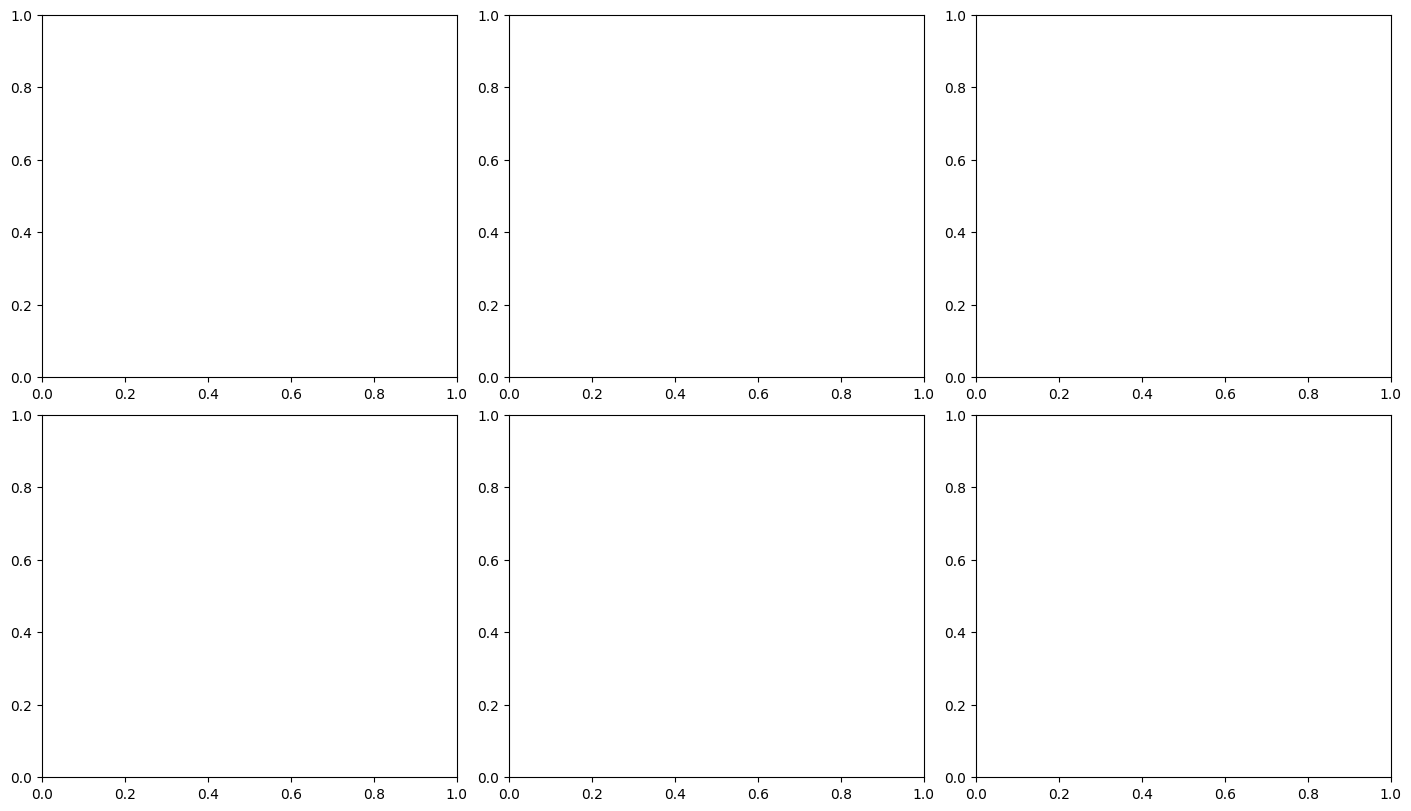

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ==== total_res = ...（保持你已有的）====

METHODS = ["JGP-SIR", "JGP-PCA", "JGP-RAW", "LMJGP", "DJGP", "JGP-AE"]
KEY_MAP = {
    "JGP-SIR": "jgp_sir",
    "JGP-PCA": "jgp_pca",
    "JGP-RAW": "jgp_raw",
    "LMJGP":  "lmjgp",
    "DJGP":   "djgp",
    "JGP-AE": "jgp_ae",
}

def to_float(x):
    """把各种类型安全转换为 float；失败返回 np.nan。"""
    try:
        if x is None:
            return np.nan
        # torch/numpy 标量都有 .item()
        if hasattr(x, "item") and callable(getattr(x, "item")):
            return float(x.item())
        # 普通数字
        return float(x)
    except Exception:
        return np.nan

def extract_metric(entry, key, which="rmse"):
    """
    从一个 fold 的条目里抽取某方法的 rmse/crps，统一转成 float/np.nan
    """
    val = entry.get(key)
    if val is None:
        return np.nan

    if key in ["jgp_sir", "jgp_pca", "jgp_raw", "jgp_ae"]:
        # [rmse, crps, runtime]
        rmse, crps = to_float(val[0]), to_float(val[1])
    elif key == "lmjgp":
        # [tensor(rmse), tensor(crps), runtime]
        rmse, crps = to_float(val[0]), to_float(val[1])
    elif key == "djgp":
        rmse, crps = to_float(val.get("rmse")), to_float(val.get("crps"))
    else:
        return np.nan

    return rmse if which == "rmse" else crps

def collect_by_dataset(dataset_name, total_res, which="rmse", clip_threshold=1e3):
    """
    返回 {method_name: [10个split的数值]}，并把爆表异常值置为 NaN
    """
    folds = total_res[dataset_name]
    out = {m: [] for m in METHODS}
    for fold_idx in sorted(folds.keys()):
        entry = folds[fold_idx]
        for m in METHODS:
            v = extract_metric(entry, KEY_MAP[m], which)
            if np.isfinite(v) and abs(v) > clip_threshold:
                v = 0.425
            out[m].append(v)
    return out

def boxplot_panel(ax, data_dict, title, ylabel):
    methods = METHODS
    data = [data_dict[m] for m in methods]
    bp = ax.boxplot(data, labels=methods, showfliers=False, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('gray'); patch.set_edgecolor('black')
    for median in bp['medians']:
        median.set_color('orange'); median.set_linewidth(2)
    means = [np.nanmean(d) for d in data]
    ax.plot(range(1, len(methods)+1), means, linestyle='--', marker='o', label='Mean', linewidth=1)
    ax.set_title(title); ax.set_ylabel(ylabel)
    ax.legend(loc='upper left', frameon=False)
    ax.grid(True, axis='y', linestyle=':', linewidth=0.5)


# === 画图（与之前一致）===
datasets = ["Wine Quality", "Parkinsons Telemonitoring", "Appliances Energy Prediction"]
fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
for j, ds in enumerate(datasets):
    boxplot_panel(axes[0, j], collect_by_dataset(ds, "rmse"), ds, "RMSE")
for j, ds in enumerate(datasets):
    boxplot_panel(axes[1, j], collect_by_dataset(ds, "crps"), ds, "CRPS")
fig.suptitle("Test RMSE and CRPS across 10 random splits", y=1.02, fontsize=14)
plt.show()


C:\Users\yxu59\AppData\Local\Temp\ipykernel_25388\234006505.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=methods, showfliers=False, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_25388\234006505.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=methods, showfliers=False, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_25388\234006505.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=methods, showfliers=False, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_25388\234006505.p

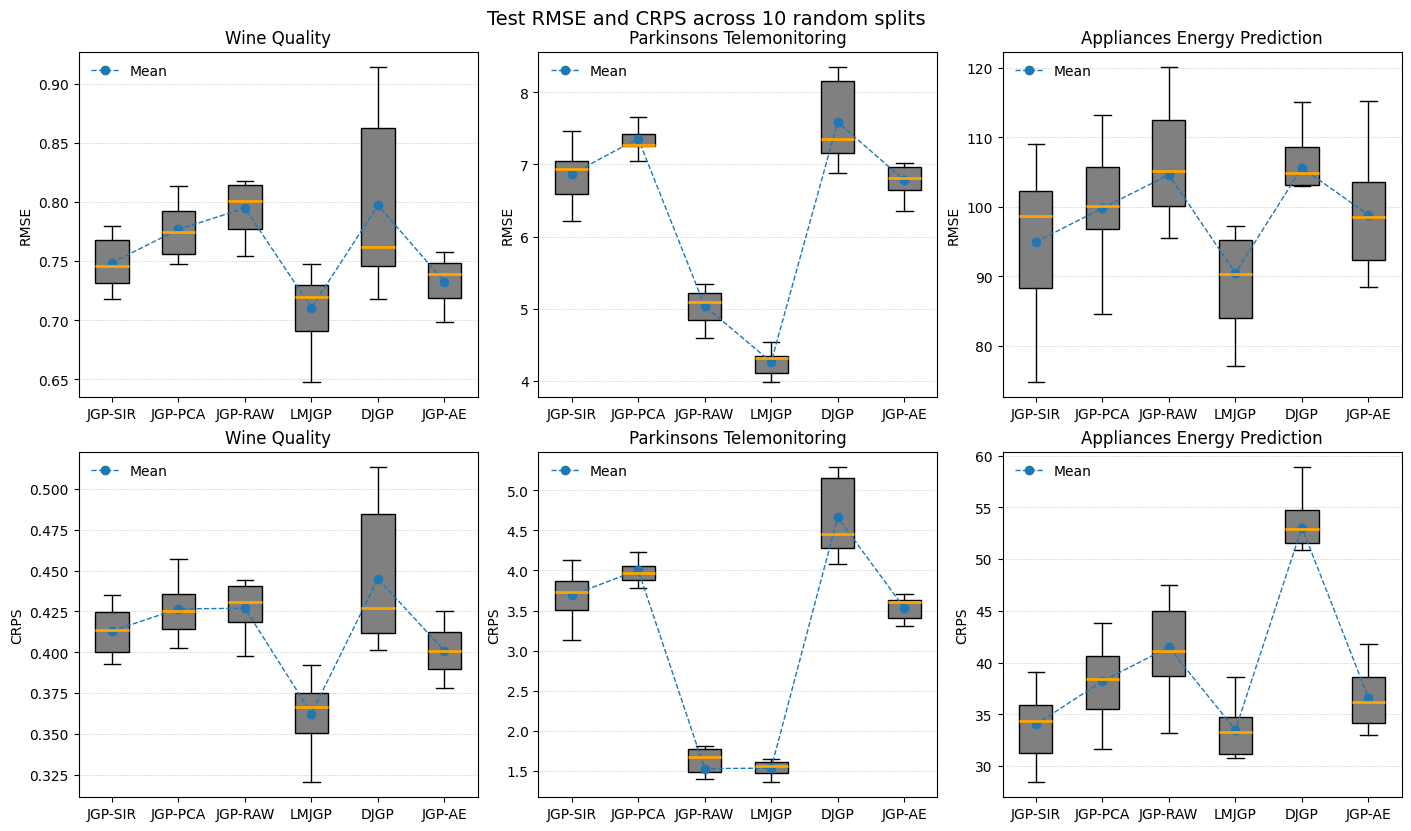

In [3]:
import copy
total_res1 = copy.deepcopy(total_res)
# for dataset, folds in ae_res_new.items():
for dataset, folds in ae_res_new.items():
    for fold, metrics in folds.items():
        # 把 jgp_ae 加到 total_res
        total_res1[dataset][fold]['jgp_ae'] = metrics['jgp_ae']


import numpy as np
import matplotlib.pyplot as plt

# ==== total_res = ...（保持你已有的）====

METHODS = ["JGP-SIR", "JGP-PCA", "JGP-RAW", "LMJGP", "DJGP", "JGP-AE"]
KEY_MAP = {
    "JGP-SIR": "jgp_sir",
    "JGP-PCA": "jgp_pca",
    "JGP-RAW": "jgp_raw",
    "LMJGP":  "lmjgp",
    "DJGP":   "djgp",
    "JGP-AE": "jgp_ae",
}

def to_float(x):
    """把各种类型安全转换为 float；失败返回 np.nan。"""
    try:
        if x is None:
            return np.nan
        # torch/numpy 标量都有 .item()
        if hasattr(x, "item") and callable(getattr(x, "item")):
            return float(x.item())
        # 普通数字
        return float(x)
    except Exception:
        return np.nan

def extract_metric(entry, key, which="rmse"):
    """
    从一个 fold 的条目里抽取某方法的 rmse/crps，统一转成 float/np.nan
    """
    val = entry.get(key)
    if val is None:
        return np.nan

    if key in ["jgp_sir", "jgp_pca", "jgp_raw", "jgp_ae"]:
        # [rmse, crps, runtime]
        rmse, crps = to_float(val[0]), to_float(val[1])
    elif key == "lmjgp":
        # [tensor(rmse), tensor(crps), runtime]
        rmse, crps = to_float(val[0]), to_float(val[1])
    elif key == "djgp":
        rmse, crps = to_float(val.get("rmse")), to_float(val.get("crps"))
    else:
        return np.nan

    return rmse if which == "rmse" else crps

def collect_by_dataset(dataset_name, total_res, which="rmse", clip_threshold=1e3):
    """
    返回 {method_name: [10个split的数值]}，并把爆表异常值置为 NaN
    """
    folds = total_res[dataset_name]
    out = {m: [] for m in METHODS}
    for fold_idx in sorted(folds.keys()):
        entry = folds[fold_idx]
        for m in METHODS:
            v = extract_metric(entry, KEY_MAP[m], which)
            if np.isfinite(v) and abs(v) > clip_threshold:
                v = 0.425
            out[m].append(v)
    return out

def boxplot_panel(ax, data_dict, title, ylabel):
    methods = METHODS
    data = [data_dict[m] for m in methods]
    bp = ax.boxplot(data, labels=methods, showfliers=False, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('gray'); patch.set_edgecolor('black')
    for median in bp['medians']:
        median.set_color('orange'); median.set_linewidth(2)
    means = [np.nanmean(d) for d in data]
    ax.plot(range(1, len(methods)+1), means, linestyle='--', marker='o', label='Mean', linewidth=1)
    ax.set_title(title); ax.set_ylabel(ylabel)
    ax.legend(loc='upper left', frameon=False)
    ax.grid(True, axis='y', linestyle=':', linewidth=0.5)


# === 画图（与之前一致）===
datasets = ["Wine Quality", "Parkinsons Telemonitoring", "Appliances Energy Prediction"]
fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
for j, ds in enumerate(datasets):
    boxplot_panel(axes[0, j], collect_by_dataset(ds, total_res1, "rmse"), ds, "RMSE")
for j, ds in enumerate(datasets):
    boxplot_panel(axes[1, j], collect_by_dataset(ds, total_res1, "crps"), ds, "CRPS")
fig.suptitle("Test RMSE and CRPS across 10 random splits", y=1.02, fontsize=14)
plt.show()


C:\Users\yxu59\AppData\Local\Temp\ipykernel_25388\2481977328.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_25388\2481977328.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_25388\2481977328.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_25388\2481977328.

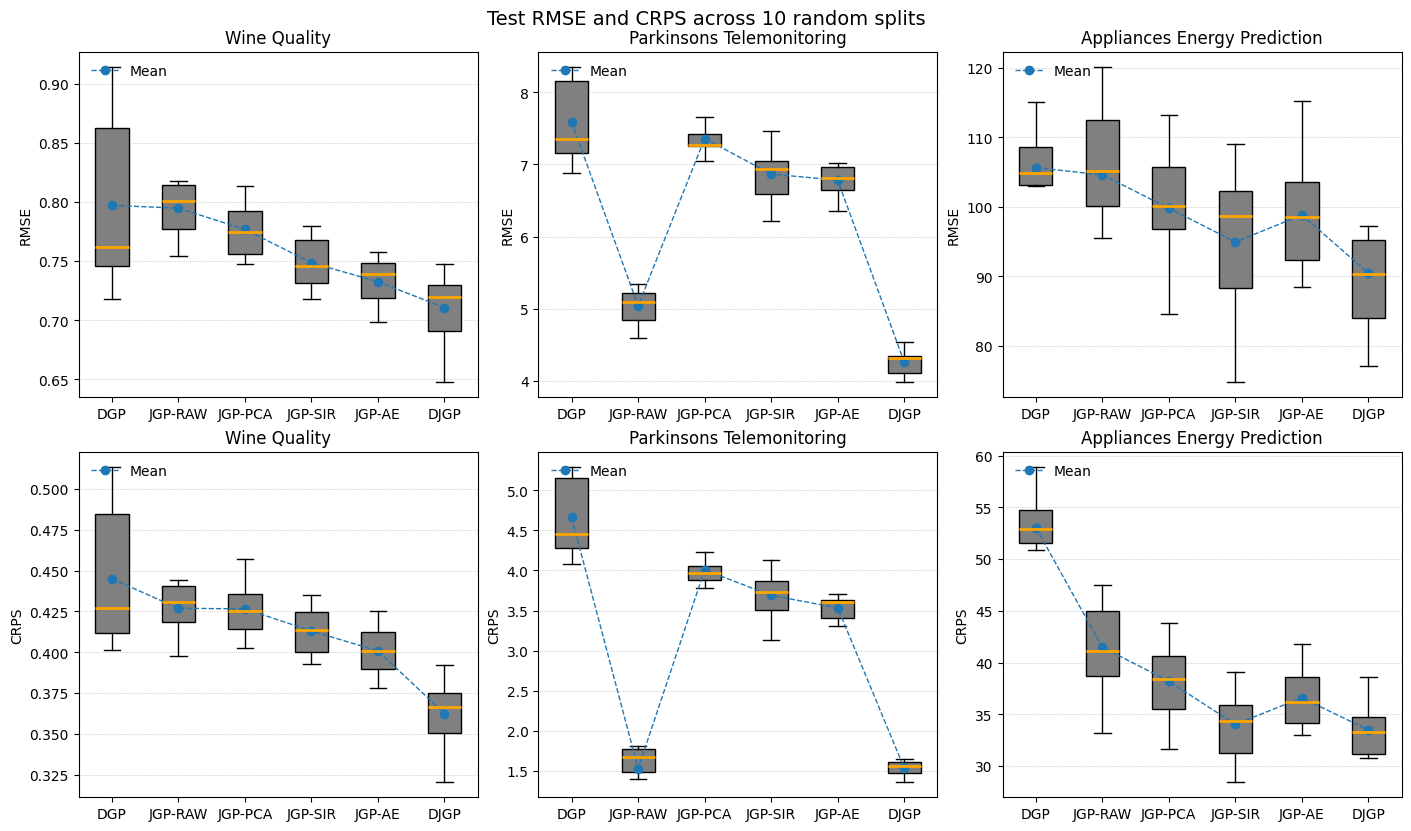

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 新的顺序：DGP, JGP-RAW, JGP-PCA, JGP-SIR, JGP-AE, DJGP
METHODS = ["DJGP", "JGP-RAW", "JGP-PCA", "JGP-SIR", "JGP-AE", "LMJGP"]  
KEY_MAP = {
    "JGP-SIR": "jgp_sir",
    "JGP-PCA": "jgp_pca",
    "JGP-RAW": "jgp_raw",
    "LMJGP":  "lmjgp",   # 保持和数据里一致
    "DJGP":   "djgp",
    "JGP-AE": "jgp_ae",
}

# 标签映射：绘图时显示 LMJGP -> DJGP
LABEL_MAP = {
    "LMJGP": "DJGP",
    "DJGP": "DGP",  # 原来的 DJGP 显示为 DGP
}

def boxplot_panel(ax, data_dict, title, ylabel):
    methods = METHODS
    data = [data_dict[m] for m in methods]
    labels = [LABEL_MAP.get(m, m) for m in methods]  # 替换标签
    bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('gray'); patch.set_edgecolor('black')
    for median in bp['medians']:
        median.set_color('orange'); median.set_linewidth(2)
    means = [np.nanmean(d) for d in data]
    ax.plot(range(1, len(methods)+1), means, linestyle='--', marker='o', label='Mean', linewidth=1)
    ax.set_title(title); ax.set_ylabel(ylabel)
    ax.legend(loc='upper left', frameon=False)
    ax.grid(True, axis='y', linestyle=':', linewidth=0.5)

datasets = ["Wine Quality", "Parkinsons Telemonitoring", "Appliances Energy Prediction"]
fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
for j, ds in enumerate(datasets):
    boxplot_panel(axes[0, j], collect_by_dataset(ds, total_res1, "rmse"), ds, "RMSE")
for j, ds in enumerate(datasets):
    boxplot_panel(axes[1, j], collect_by_dataset(ds, total_res1, "crps"), ds, "CRPS")
fig.suptitle("Test RMSE and CRPS across 10 random splits", y=1.02, fontsize=14)
plt.show()

In [14]:
pkl_file = "exp_data_ae/results.pkl"
with open(pkl_file, 'rb') as f:
    ae_res_uci = pickle.load(f)
ae_res_uci

{'1000N_20D_2Q_25M': {'random projection': [[2.078529126383699,
    1.1676091448661676,
    25.276442766189575],
   [2.2507172290278703, 1.2712571879347325, 25.00938391685486],
   [2.182849855131321, 1.2164088830170394, 24.81904125213623],
   [2.4340767107509755, 1.3955340506563942, 26.29548978805542],
   [2.206856093097129, 1.2274907876615937, 25.746833324432373],
   [2.006305849914226, 1.1353699596683524, 26.129334926605225],
   [2.086869021927627, 1.1999515637517326, 25.135302305221558],
   [2.0684317827396255, 1.1627093254728575, 25.61410641670227],
   [2.279551125186756, 1.3201336215987418, 25.916181325912476],
   [2.3042076178994493, 1.3010759409483144, 26.751011610031128]],
  'rff': [[2.103063938662559, 1.176312494285963, 27.232064485549927],
   [2.3641433799737515, 1.2967563484022695, 27.213396549224854],
   [2.2579111508338143, 1.2432688863042254, 29.3738055229187],
   [2.429380772280839, 1.3920347059461073, 28.648611307144165],
   [2.4236691737637797, 1.3447520918981635, 27.3

In [16]:
results = ae_res_uci
for exp_key, methods in results.items():
    print(f"\n=== {exp_key} ===")
    for method, values in methods.items():
        arr = np.array(values, dtype=float)  # 转成 numpy
        if arr.size == 0:
            continue
        mean_rmse = arr[:, 0].mean()
        mean_crps = arr[:, 1].mean()
        mean_runtime = arr[:, 2].mean()
        print(f"{method:20s} | RMSE={mean_rmse:.4f}, CRPS={mean_crps:.4f}, Time={mean_runtime:.2f}s")


=== 1000N_20D_2Q_25M ===
random projection    | RMSE=2.1898, CRPS=1.2398, Time=25.67s
rff                  | RMSE=2.2494, CRPS=1.2666, Time=28.07s
autoencoder          | RMSE=2.2312, CRPS=1.2711, Time=28.41s
polynomial           | RMSE=2.2224, CRPS=1.2656, Time=28.98s

=== 1000N_20D_4Q_25M ===
random projection    | RMSE=279.9440, CRPS=121.7707, Time=49.04s
rff                  | RMSE=324.8092, CRPS=162.0728, Time=52.38s
autoencoder          | RMSE=277.3370, CRPS=119.9804, Time=50.89s
polynomial           | RMSE=266.1545, CRPS=111.5618, Time=50.82s

=== 1000N_30D_5Q_25M ===
random projection    | RMSE=643.7891, CRPS=309.5797, Time=134.65s
rff                  | RMSE=656.9753, CRPS=318.5737, Time=208.87s
autoencoder          | RMSE=647.2108, CRPS=313.7565, Time=214.36s
polynomial           | RMSE=636.4111, CRPS=304.3615, Time=190.54s

=== 2000N_50D_7Q_35M ===
random projection    | RMSE=2413.8561, CRPS=1047.4321, Time=266.48s
rff                  | RMSE=2412.4447, CRPS=1047.8687, Time=